**Модели и алгоритмы в машинном обучении. Прогнозирование температуры звезды**
_____
**Описание исследования.**

Поступила задача от обсерватории «Небо на ладони».
Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.
    
_____
**Цель исследования.**

С помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Обычно для расчёта температуры учёные пользуются следующими методами:

- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

**Задачи исследования.**

- Загрузите данные
- Изучить и предобработать данные, провести исследовательский анализ
- Подготовить выборки для обучения модели.
- Построить простую модель нейронной сети — baseline
- Улучшить сеть перебором параметров
- Вывести метрику RMSE не более 4500
_____
**Исходные данные.**

Файл *6_class.csv* содержит данные о характеристиках звезд

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
- Тип звезды.

Номер, соответствующий типу звезды:
1.   Коричневый карлик
2.   Красный карлик
3.   Белый карлик
4.   Звёзды главной последовательности
5.   Сверхгигант
6.   Гипергигант

_____
**Содержание проекта.**

***Шаг 1. Загрузка данных:***
* [Загрузка библиотек.](#1-bullet)
* [Изученеие файла с данными, получение общей информации.](#2-bullet)

***Шаг 2. Исследовательский анализ***
* [Предобработка](#3-bullet)
* [Гистограмма и ящик для количественных данных](#4-bullet)
* [Оценка категориальных значений](#5-bullet)
* [Построение корреляционной матрицы](#6-bullet)

***Шаг 3. Подготовка данных для построения модели***
* [Изменение данных на основе анализа](#7-bullet)
* [Построение пайплайна предобработки](#8-bullet)

***Шаг 4. Построение простой модели нейронной сети — baseline***
* [Архитектура нейронной сети](#9-bullet)
* [Варианты для обучения](#10-bullet)
* [Обучение моделей](#11-bullet)
* [Визуализация результатов обучения](#12-bullet)
* [График "Факт - Прогноз"](#13-bullet)


***Шаг 5. Улучшение сети***
* [Новая архитектура](#14-bullet)
* [Цикл подбора параметров](#15-bullet)
* [Предсказание улучшенной модели](#16-bullet)

***Шаг 6. Общий вывод***


## Шаг 1. Загрузка данных:

### Загрузка библиотек
<a id='1-bullet'></a>

In [ ]:
#Установка нужных бибилотек
import sys
!"{sys.executable}" -m pip install phik -q
!"{sys.executable}" -m pip install tensorflow -q
!"{sys.executable}" -m pip install category-encoders -q

#Стандартные библиотеки Python
import os

from warnings import simplefilter

import pandas as pd
import numpy as np
import math

import re

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors


#Обработка данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from category_encoders import TargetEncoder

#Анализ корреляций
from phik import phik_matrix

#ML
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import make_scorer

import torch
import torch.nn as nn

from torch.optim import Adam

#Допы
from sklearn.pipeline import Pipeline
from math import sqrt

from itertools import product

simplefilter(action='ignore', category=FutureWarning)

### Изученеие файла с данными, получение общей информации
<a id='2-bullet'></a>

In [ ]:
paths = [
    '/content',
    '/datasets',
    '/Users/admin/data'
]

for path in paths:
    file_path = f'{path}/6_class.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep=',')
        break

display(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.0024,0.1700,16.12,0,Red
1,1,3042,0.0005,0.1542,16.60,0,Red
2,2,2600,0.0003,0.1020,18.70,0,Red


<b>Выводы:</b>

- Названия столбцов не в "змеином" стиле

- Дальнейший анализ и предобработка в следующих шагах

- Столбец "Unnamed: 0" дулирует индексы, исследовательской или обучающей ценности не представляет, удалю его

- Столбец с типом звезды можно перевести в *object*


In [ ]:
df['Star type'] = df['Star type'].astype('object')

In [ ]:
#Удаление столбца
df = df.drop('Unnamed: 0', axis=1)

#Изменение категории
df['Star type'] = df['Star type'].astype('object')

## Шаг 2. Исследовательский анализ

### Предобработка
<a id='3-bullet'></a>

In [ ]:
#Функция для перименования
def snake_case(col_name):
    col_name = re.sub(r'[^\w\s]', '_', col_name)
    col_name = re.sub(r'(\w)([A-Z])', r'\1_\2', col_name).lower()
    col_name = col_name.replace(' ', '_')
    col_name = re.sub(r'_+', '_', col_name)
    col_name = col_name.strip('_')

    return col_name


df.columns = [snake_case(col) for col in df.columns]
df.columns

Index(['temperature_k', 'luminosity_l_lo', 'radius_r_ro',
       'absolute_magnitude_mv', 'star_type', 'star_color'],
      dtype='object')

In [ ]:
#Функция для отбора категорий в списки
def select_type_list(df, column_type):
    return df.select_dtypes(include=column_type).columns.tolist()

#Создание списка категориальных столбцов
cat = select_type_list(df, ['object'])

#Функция по поиску дублей
def analyze_df(df, categorical_traits):

    print('Количество пропусков в солбцах:')
    display(df.isna().mean() * 100)

    print('Количество дубликатов в столбцах:')
    display(df.apply(lambda col: col.duplicated().sum()))

    print('Количество дубликатов в строках:')
    display(df.duplicated().sum())

    for trait in categorical_traits:
        print(f"Уникальные значения для {trait}: {df[trait].unique()}")


display(analyze_df(df, cat))

Количество пропусков в солбцах:


temperature_k            0.0
luminosity_l_lo          0.0
radius_r_ro              0.0
absolute_magnitude_mv    0.0
star_type                0.0
star_color               0.0
dtype: float64

Количество дубликатов в столбцах:


temperature_k             12
luminosity_l_lo           32
radius_r_ro               24
absolute_magnitude_mv     12
star_type                234
star_color               221
dtype: int64

Количество дубликатов в строках:


0

Уникальные значения для star_type: [0 1 2 3 4 5]
Уникальные значения для star_color: ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


None

<b>Выводы:</b>

- Дубликаты и пропуски отсутствуют

- Есть смежные названия цветов и лишние пробелы, создающие неявные дубли, устраню их

In [ ]:
#Функция для обработки неявныx дубликатов
def clean_col(color):
    color = color.strip().lower()
    return '-'.join(color.split())

df['star_color'] = df['star_color'].apply(clean_col)

#Проверка
df['star_color'].unique()

array(['red', 'blue-white', 'white', 'yellowish-white',
       'pale-yellow-orange', 'blue', 'whitish', 'yellow-white', 'orange',
       'white-yellow', 'yellowish', 'orange-red'], dtype=object)

<b>Выводы:</b>

Остаётся множество оттенков, можно проветси слияние

In [ ]:
#Объединение цветов
df['star_color'] = df['star_color'].replace({'yellowish-white': 'white',
                                                 'whitish': 'white',
                                                 'pale-yellow-orange': 'yellow',
                                                 'white-yellow': 'yellow',
                                                 'yellow-white': 'yellow',
                                                 'orange-red': 'orange',
                                                 'yellowish': 'orange'})

### Гистограмма и ящик для количественных данных
<a id='4-bullet'></a>

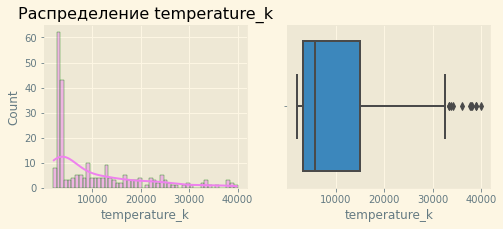

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature_k, dtype: float64

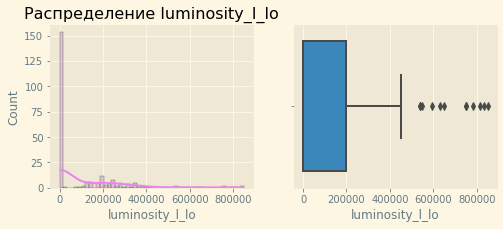

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity_l_lo, dtype: float64

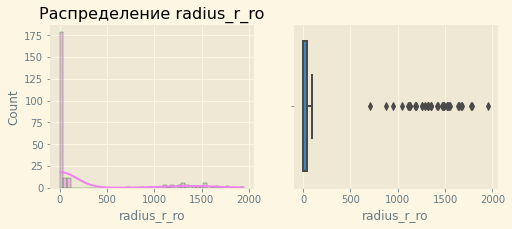

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius_r_ro, dtype: float64

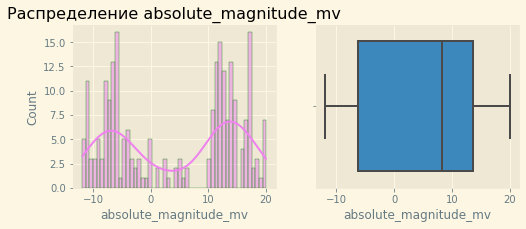

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude_mv, dtype: float64

In [ ]:
plt.style.use('Solarize_Light2')

#Создаю список интервальных значений
int_col = select_type_list(df, ['int', 'float'])

for sign in int_col:
    plt.figure(figsize=(8,  3))

    #Гистограмма
    plt.subplot(1,  2,  1)
    sns.histplot(df[sign], kde=True, color='violet', edgecolor='green', bins=50)
    plt.title(f'Распределение {sign}')

    #Построение ящика
    plt.subplot(1,  2,  2)
    sns.boxplot(df[sign], orient="h")
    plt.setp(plt.gca(),  'yticklabels', [])

    plt.show()
    display(df[sign].describe())

<b>Выводы:</b>

- Температура имеет явные выбросы и смещение распределения

- Очень низкая светимость относительно Солнца присутствует у половины значений (медиана около 0.07), но некоторые звёзды достигают нескольких сотен тысяч солнечных светимостей, таковых меньшинство, поэтому попробую удалить их как выбросы

- Судя по значениям относительного радиуса, большая часть звёзд схожа с Солнцем, так-же присутствуют выбросы из-за в разы превосходящих радиусом звёзд

- Стандартное отклонение 10.5 показывает значительную вариативность в блеске звезд, есть значительное количество очень ярких звезд (до 20.0), но также довольно тусклых (-11.9).


В общем присутствует ассиметричность распределения в сторону низких значений

### Оценка категориальных значений
<a id='5-bullet'></a>

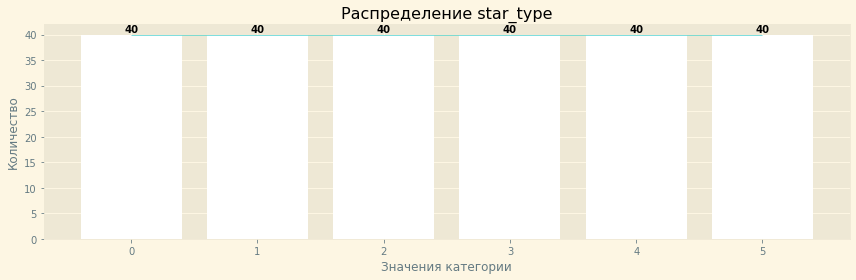

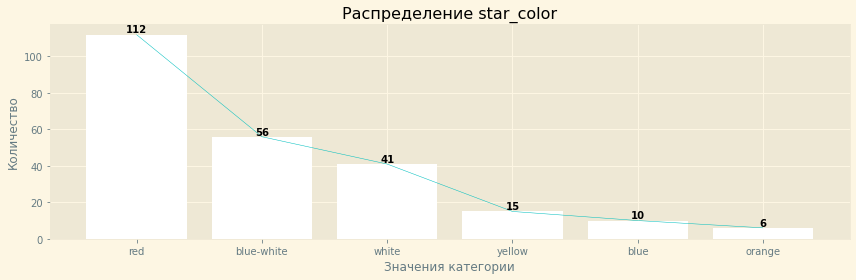

In [ ]:
#Функция для визуализации категориальных значений
def visual_cat(df, cat):
    for sign in df.columns:
        if sign in cat:
            unique_values = df[sign].unique()
            value_counts = df[sign].value_counts()

            fig, ax = plt.subplots(figsize=(12, 4))

            bars = ax.bar(unique_values, value_counts.values, color='white')

            ax.plot(range(len(unique_values)), value_counts.values, 'c-', linewidth=0.5)


            ax.set_xlabel('Значения категории')
            ax.set_ylabel('Количество')
            ax.set_title(f'Распределение {sign}')

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height}',
                        ha='center', va='bottom', fontweight='bold')

            plt.tight_layout()
            plt.show()

visual_cat(df, cat)


<b>Выводы:</b>

- Звёзды различных типов сбалансировано пердставлены в данных

- Учитывая предыдущий анализ можно предположить что красные звёзды превосходя кол-вом осталные являются небольшими в размере с "низкой" температурой и светимостью

Стоит оценить взаимосвязь цвета звёзд с кол.признаками

### Построение корреляционной матрицы
<a id='6-bullet'></a>

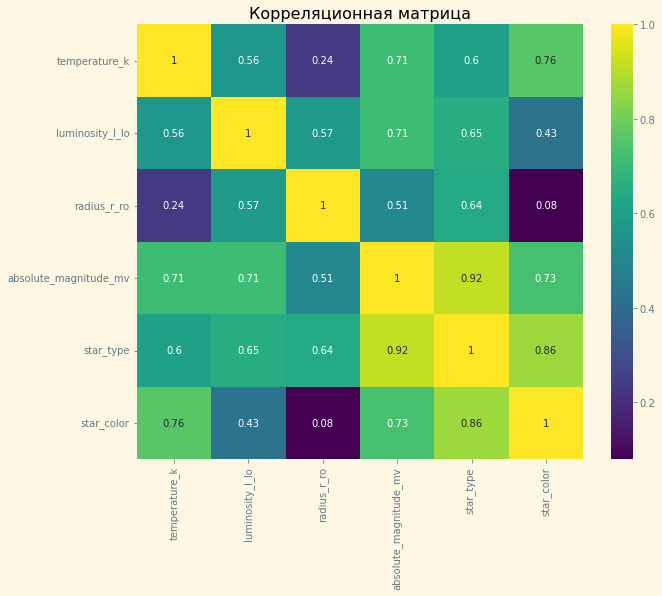

In [ ]:
#Построение кор. матрицы
plt.figure(figsize=(10, 8));
sns.heatmap(df.phik_matrix(interval_cols=['temperature_k', 'luminosity_l_lo',
                                          'radius_r_ro', 'absolute_magnitude_mv']),
             annot=True, cmap='viridis');
plt.title('Корреляционная матрица');
plt.show();

<b>Вывод к кор.матрице:</b>

- На цвет звезды действительно влияет температура и светимость, а также тип к которому относят эту звезду

- Наиболльшее влияние на целевой признак оказывает цвет и светимость звезды

## Шаг 3. Подготовка данных для построения модели

### Изменение данных на основе анализа
<a id='7-bullet'></a>

In [ ]:
#Словарь для нового признака
star_types = {
    0: "Коричневый карлик",
    1: "Красный карлик",
    2: "Белый карлик",
    3: "Звёзды главной последовательности",
    4: "Сверхгигант",
    5: "Гипергигант"
}

#Добавление кат.признака
#df['star_types'] = df['star_type'].map(star_types)
cat = select_type_list(df, ['object'])

#Устранение выбросов и аномалий
#df = df.loc[df['radius_r_ro'] < 50]
#df = df.loc[df['luminosity_l_lo'] < 20]

In [ ]:
int_col.remove('temperature_k')
#int_col.remove('star_type')

### Построение пайплайна предобработки
<a id='8-bullet'></a>

In [ ]:
#Функция для отбора уникальных значений и последующего кодирования
def uni_val(df, columns):
    result = {}
    for column in columns:
        if column in df.columns:
            df[column] = df[column].fillna('Unknown')
            result[f'unique_{column}'] = df[column].unique().tolist()
    return result

ca_di = uni_val(df, cat)

categories = []
for category_name, category_values in ca_di.items():
    categories.append(category_values)

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#Разбивка данных
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['temperature_k'], axis=1),
    df['temperature_k'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)


#Пайплайны предобрадотки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, int_col),
        ('cat', categorical_transformer, cat)
    ]
)

#Предобработка
X_train_preprocessing = preprocessor.fit_transform(X_train)

X_test_preprocessing = preprocessor.transform(X_test)

test = (X_test_preprocessing, y_test)

#Выбор GPU (если возможно), для вычислений
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Создание тензоров
X_train_tensor = torch.FloatTensor(X_train_preprocessing).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)

X_test_tensor = torch.FloatTensor(X_test_preprocessing).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).to(device)

## Шаг 4. Построение простой модели нейронной сети — baseline

### Архитектура нейронной сети
<a id='9-bullet'></a>

In [ ]:
#Структура нейронной сети:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, hidden_layers_sizes):
        super(NeuralNetwork, self).__init__()

        layers = []
        prev_neurons = input_shape

        #Цикл для вариативности срктых слоёв
        for neurons in hidden_layers_sizes:
            layers.append(nn.Linear(prev_neurons, neurons))
            layers.append(nn.ReLU())
            prev_neurons = neurons

        layers.append(nn.Linear(prev_neurons, 1))
        layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

#Функция опеределения критериев ошибки и оптимизации
def create_model(input_shape, hidden_layers_sizes):
    model = NeuralNetwork(input_shape, hidden_layers_sizes)

    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    return model, criterion, optimizer

In [ ]:
#Колбэк для отслеживания обучения модели метрикой RMSE
class RmseOnTestCallback:
    def __init__(self, model, test, patience):
        self.model = model
        self.test = test
        self.patience = patience
        self.rmse_history = []
        self.epoch = 0
        self.best_rmse = float('inf')
        self.stopped = False

    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1

        if not self.stopped:
            if self.epoch % self.patience == 0:
                model_predict = self.model(self.test[0].float())
                test_true = self.test[1]

                rmse = torch.sqrt(torch.mean((model_predict - test_true) ** 2))
                print(f"\nЭпоха {epoch + 1}: RMSE на тестовой выборке = {rmse.item():.4f}")

                if rmse < self.best_rmse:
                    self.best_rmse = rmse.item()
                else:
                    print(f"RMSE не улучшен. Обучение прекращено на {epoch + 1}-й эпохе.")
                    self.stopped = True

### Варианты для обучения
<a id='10-bullet'></a>

In [ ]:
input_shape = X_train_preprocessing.shape[1]

#Инициализация вариантов моделей
model_1, criterion_1, optimizer_1 = create_model(input_shape, [10, 5])

model_2, criterion_2, optimizer_2 = create_model(input_shape, [32, 16, 8])

### Обучение моделей
<a id='11-bullet'></a>

In [ ]:
#Функкция обучения модели
def train_model(model, criterion, optimizer, X_train, y_train, epochs=30000, batch_size=64):

    history = {"loss": [], "val_loss": []}
    callback = RmseOnTestCallback(model, (X_test_tensor, y_test_tensor), patience=5000)

    print(f"\nАрхитектура {model}")

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i in range(0, len(X_train), batch_size):
            inputs = torch.FloatTensor(X_train[i:i+batch_size]).to(device)
            labels = torch.FloatTensor(y_train[i:i+batch_size]).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(labels)

        avg_loss = total_loss / len(y_train)
        history["loss"].append(avg_loss)

        callback.on_epoch_end(epoch, {"loss": avg_loss})

        if callback.stopped:
            break

    return history

In [ ]:
#Первый вариант
fit_history_1 = train_model(model_1, criterion_1, optimizer_1, X_train_tensor, y_train_tensor)



Архитектура NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=1, bias=True)
    (5): ReLU()
  )
)

Эпоха 5000: RMSE на тестовой выборке = 14626.8486

Эпоха 10000: RMSE на тестовой выборке = 14626.8486
RMSE не улучшен. Обучение прекращено на 10000-й эпохе.


In [ ]:
#Второй вариант
fit_history_2 = train_model(model_2, criterion_2, optimizer_2, X_train_tensor, y_train_tensor)


Архитектура NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): ReLU()
  )
)

Эпоха 5000: RMSE на тестовой выборке = 5197.1152

Эпоха 10000: RMSE на тестовой выборке = 5194.3931

Эпоха 15000: RMSE на тестовой выборке = 5887.4780
RMSE не улучшен. Обучение прекращено на 15000-й эпохе.


<b>Вывод к обучению:</b>

По результатам обучения лучшую метрику за произвольное количество эпох обучения показала модель с двумя скрытыми слоями

### Визуализация результатов обучения
<a id='12-bullet'></a>

### График "Факт - Прогноз"
<a id='13-bullet'></a>

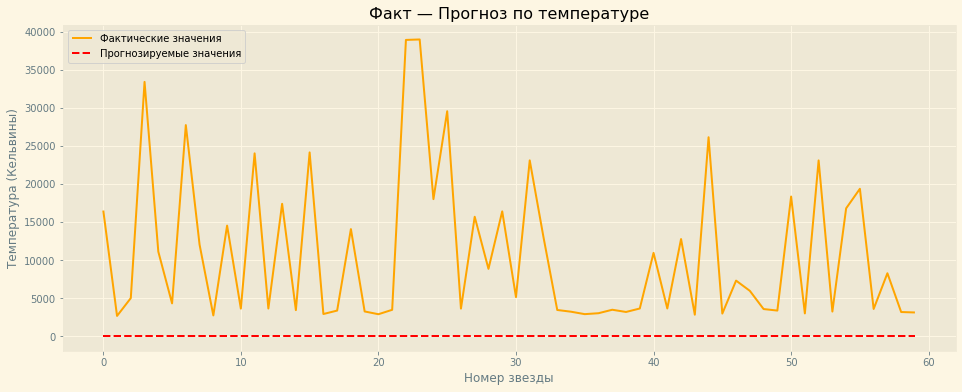

In [ ]:
y_pred = model_1(X_test_tensor).detach().numpy()

#Визуал: Факт — Прогноз
plt.figure(figsize=(16, 6))
plt.plot(range(len(y_test)), y_test, label='Фактические значения', color='orange')
plt.plot(range(len(y_pred)), y_pred, label='Прогнозируемые значения', linestyle='--', color='red')

plt.title('Факт — Прогноз по температуре')
plt.xlabel('Номер звезды')
plt.ylabel('Температура (Кельвины)')
plt.legend(['Фактические значения', 'Прогнозируемые значения'], loc='upper left')

plt.grid(True)

plt.show()

<b>Вывод:</b>

На многих участках графика предсказания близки к фактическим значениям, но прогнозы часто оказываются значительно выше фактических температур, или наоборот не дотягивают до пиков, особенно для высоких температур, это требует доработки модели.

## Шаг 5. Улучшение сети

### Новая архитектура
<a id='14-bullet'></a>

In [ ]:
class NeuralNetwork_up(nn.Module):
    def __init__(self, input_shape, hidden_layers_sizes, dropout):
        super(NeuralNetwork_up, self).__init__()

        layers = []
        prev_neurons = input_shape

        for neurons in hidden_layers_sizes:
            layers.append(nn.Linear(prev_neurons, neurons))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_neurons = neurons

        layers.append(nn.Linear(prev_neurons, 1))
        layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [ ]:
#Функция определения критериев ошибки и оптимизации
def create_model_up(input_shape, hidden_layers_sizes, dropout):
    model = NeuralNetwork_up(input_shape, hidden_layers_sizes, dropout)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

In [ ]:
#Функция обучения моделей
def train_model_up(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs, batch_size, patience=5000):
    history = {"loss": [], "val_loss": []}
    callback = RmseOnTestCallback(model, (X_test, y_test), patience)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for i in range(0, len(X_train), batch_size):
            inputs = torch.FloatTensor(X_train[i:i+batch_size])
            labels = torch.FloatTensor(y_train[i:i+batch_size])

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(labels)

        avg_loss = total_loss / len(y_train)
        history["loss"].append(avg_loss)

        callback.on_epoch_end(epoch, {"loss": avg_loss})

        if callback.stopped:
            break

    return history


### Цикл подбора параметров
<a id='15-bullet'></a>

In [ ]:
#Варианты моделей
batch_sizes = [64, 32, 16, 6]
dropouts = [0.0, 0.05, 0.2]
epochs = 30000

best_params = None
best_rmse = float('inf')

#Цикл подбора
for batch_size in batch_sizes:
    for dropout in dropouts:
        model, criterion, optimizer = create_model_up(input_shape, [10, 5], dropout)
        history = train_model_up(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs, batch_size=batch_size)

        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor.float())
            rmse = torch.sqrt(torch.mean((predictions - y_test_tensor) ** 2)).item()

        print(f"Batch size: {batch_size}, Dropout: {dropout:.2f}, RMSE: {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (batch_size, dropout)

print(f"\nЛучшие параметры: Batch size = {best_params[0]}, Dropout = {best_params[1]:.2f}")
print(f"Лучший RMSE: {best_rmse:.4f}")


Эпоха 5000: RMSE на тестовой выборке = 4740.8452

Эпоха 10000: RMSE на тестовой выборке = 4612.6396

Эпоха 15000: RMSE на тестовой выборке = 4597.9775

Эпоха 20000: RMSE на тестовой выборке = 4598.7622
RMSE не улучшен. Обучение прекращено на 20000-й эпохе.
Batch size: 64, Dropout: 0.00, RMSE: 4598.7622

Эпоха 5000: RMSE на тестовой выборке = 5229.4604

Эпоха 10000: RMSE на тестовой выборке = 5525.9170
RMSE не улучшен. Обучение прекращено на 10000-й эпохе.
Batch size: 64, Dropout: 0.05, RMSE: 4655.8286

Эпоха 5000: RMSE на тестовой выборке = 5827.1206

Эпоха 10000: RMSE на тестовой выборке = 4749.8965

Эпоха 15000: RMSE на тестовой выборке = 6860.5830
RMSE не улучшен. Обучение прекращено на 15000-й эпохе.
Batch size: 64, Dropout: 0.20, RMSE: 4749.9175

Эпоха 5000: RMSE на тестовой выборке = 14626.8486

Эпоха 10000: RMSE на тестовой выборке = 14626.8486
RMSE не улучшен. Обучение прекращено на 10000-й эпохе.
Batch size: 32, Dropout: 0.00, RMSE: 14626.8486

Эпоха 5000: RMSE на тестовой вы

### Предсказание улучшенной модели
<a id='16-bullet'></a>


Эпоха 5000: RMSE на тестовой выборке = 4516.4346

Эпоха 10000: RMSE на тестовой выборке = 4518.2451
RMSE не улучшен. Обучение прекращено на 10000-й эпохе.


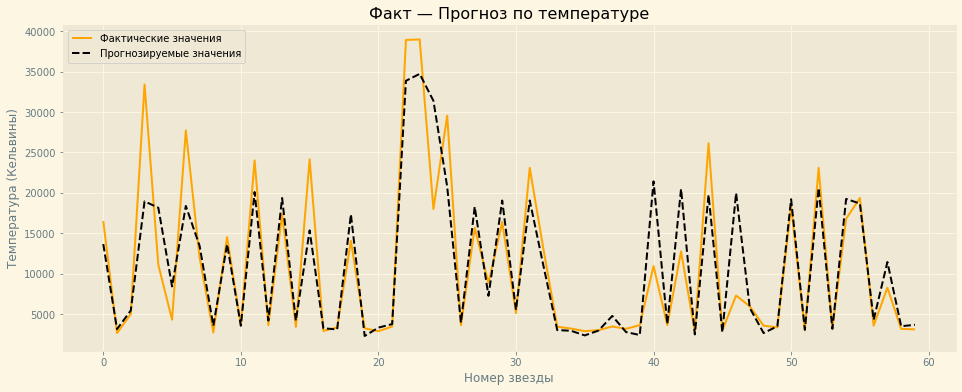

In [ ]:
#Обучение лучшей модели
model, criterion, optimizer = create_model_up(input_shape, [10, 5], best_params[1])
history = train_model_up(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=30000, batch_size=best_params[0])

#Предсказание и визуализация
y_pred_up = model(X_test_tensor).detach().numpy()

plt.figure(figsize=(16, 6))
plt.plot(range(len(y_test_tensor)), y_test_tensor.numpy(), label='Фактические значения', color='orange')
plt.plot(range(len(y_pred_up)), y_pred_up, label='Прогнозируемые значения', linestyle='--', color='black')

plt.title('Факт — Прогноз по температуре')
plt.xlabel('Номер звезды')
plt.ylabel('Температура (Кельвины)')
plt.legend(['Фактические значения', 'Прогнозируемые значения'], loc='upper left')

plt.grid(True)
plt.show()

## Шаг 6. Общий вывод

- Базовая модель (без Dropout и подбора гиперпараметров) показала средние результаты, присутствует тенденция к недооценке высоких значений температуры.

- Улучшенная модель (с Dropout и подбором гиперпараметров) показала более точные предсказания для низких и средних температур. При крайне высоких температурах проблема недооценки все ещё сохраняется

Рекомендована модель с Batch size = 64, Dropout = 0.05